# Download and process the Bay Area's walkable network

In [1]:
import time
import os, zipfile, requests, pandas as pd, geopandas as gpd, osmnx as ox, networkx as nx

ox.config(use_cache=True, log_console=True)
print('ox {}\nnx {}'.format(ox.__version__, nx.__version__))
start_time = time.time()

ox 0.7.3.dev
nx 2.2rc1.dev_20180312012810


In [2]:
# point to the shapefile for counties
counties_shapefile_url = 'http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_county_500k.zip'

# identify bay area counties by fips code
bayarea = {'Alameda':'001',
           'Contra Costa':'013',
           'Marin':'041',
           'Napa':'055',
           'San Francisco':'075',
           'San Mateo':'081',
           'Santa Clara':'085',
           'Solano':'095',
           'Sonoma':'097'}

## Download and extract the counties shapefile if it doesn't already exist, then load it

To use OSMnx, we need a polygon of the Bay Area's nine counties. So, we'll download a shapefile from the census, extract our counties, and take the union to form a polygon. Also, project the polygon so we can calculate its area for density stats.

In [3]:
counties_shapefile_zip = counties_shapefile_url[counties_shapefile_url.rfind('/') + 1 :]
counties_shapefile_dir = counties_shapefile_zip[: counties_shapefile_zip.rfind('.zip')]
if not os.path.exists(counties_shapefile_dir):
    response = requests.get(counties_shapefile_url)
    with open(counties_shapefile_zip, 'wb') as f:
        f.write(response.content)
        with zipfile.ZipFile(counties_shapefile_zip, 'r') as zip_file:
            zip_file.extractall(counties_shapefile_dir)
    os.remove(counties_shapefile_zip)

In [4]:
counties = gpd.read_file(counties_shapefile_dir)
len(counties)

3233

In [5]:
# retain only those tracts that are in the bay area counties
mask = (counties['STATEFP'] == '06') & (counties['COUNTYFP'].isin(bayarea.values()))
gdf_bay = counties[mask]
len(gdf_bay)

9

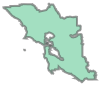

In [6]:
bayarea_polygon = gdf_bay.unary_union
bayarea_polygon

In [7]:
# get the convex hull, otherwise we'll cut out bridges over the bay
bayarea_polygon_hull = bayarea_polygon.convex_hull
bayarea_polygon_hull_proj, crs = ox.project_geometry(bayarea_polygon_hull)

In [8]:
# project by a mile to get connectivities surrounding our O-Ds
bayarea_polygon_hull_proj_buff = bayarea_polygon_hull_proj.buffer(1600) #1 mile in meters
bayarea_polygon_hull_buff, crs = ox.project_geometry(bayarea_polygon_hull_proj_buff, crs=crs, to_latlong=True)

## Download the street network

Now we've got our polygon of the buffered convex hull around the nine county bay area. Use OSMnx to download the street network (walkable paths) and simplify its topology. Setting `retain_all=False` means we only keep the largest (weakly) connected component. In the bay area, this means we keep only the southern 3/4 of the network. The northern part is not connected.

In [9]:
# download full walkable network and simplify its topology
G = ox.graph_from_polygon(bayarea_polygon_hull_buff, network_type='walk',
                          simplify=True, retain_all=False)

In [10]:
# verify that our graph is strongly connected, should be if it's a walkable network and we
# already retained only the largest weakly connected component
assert nx.is_strongly_connected(G)

In [11]:
# create a unique ID for each edge because osmid can hold multiple values due to topology simplification
i = 0
for u, v, k, d in G.edges(data=True, keys=True):
    d['uniqueid'] = i
    i += 1

## See some descriptive stats then save to disk

In [12]:
print(len(G.nodes()))
print(len(G.edges()))

415716
1162974


In [13]:
# see some basic network stats
# note, areas/densities include water
pd.Series(ox.basic_stats(G, area=bayarea_polygon_hull_proj_buff.area))

circuity_avg                                                               1.15572
clean_intersection_count                                                      None
clean_intersection_density_km                                                 None
edge_density_km                                                            4081.52
edge_length_avg                                                            100.101
edge_length_total                                                      1.16415e+08
intersection_count                                                          336757
intersection_density_km                                                    11.8067
k_avg                                                                      5.59504
m                                                                          1162974
n                                                                           415716
node_density_km                                                             14.575
self

In [14]:
# save nodes and edges list as csv
nodes, edges = ox.graph_to_gdfs(G, node_geometry=False, fill_edge_geometry=False)

ecols = ['uniqueid', 'u', 'v', 'key', 'oneway', 'highway', 'name', 'length',
         'lanes', 'width', 'est_width', 'maxspeed', 'access', 'service',
         'bridge', 'tunnel', 'area', 'junction', 'osmid', 'ref']

edges = edges.drop(columns=['geometry']).reindex(columns=ecols)
nodes = nodes.reindex(columns=['osmid', 'x', 'y', 'ref', 'highway'])

nodes.to_csv('data/walk_network_connected/bay_area_walk_nodes.csv', index=False, encoding='utf-8')
edges.to_csv('data/walk_network_connected/bay_area_walk_edges.csv', index=False, encoding='utf-8')

In [15]:
# save as graphml for re-using later
ox.save_graphml(G, filename='bayarea_walk_simplified.graphml', folder='data/walk_network_connected')

In [16]:
# save as shapefile for GIS
ox.save_graph_shapefile(G, filename='bayarea_walk_simplified', folder='data/walk_network_connected')

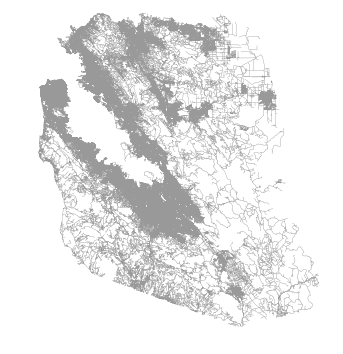

In [17]:
# visualize the network
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.2)

In [18]:
time.time() - start_time

2677.1988117694855